In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

### Data loading

In [6]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model.pth',map_location=torch.device('cpu'))['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)
inverse_model.load_state_dict(torch.load('./models/inverse_model.pth',map_location=torch.device('cpu'))['model_state_dict'])
inverse_model.eval()
dataset=test_loader.dataset;
with torch.no_grad():
    mean, std = torch.tensor(dataset.scaler.mean_).to(DEVICE), torch.tensor(np.sqrt(dataset.scaler.var_)).to(DEVICE)
    x, y = dataset.x.to(DEVICE), dataset.y.to(DEVICE)
    x_dim = x.size()[1]

        # get MSE for the design
    y_pred = inverse_model(x, y)
print(y)

tensor([[ 1.4638,  1.3646, -0.4958,  0.6326],
        [ 1.4638,  1.6667, -1.0289,  0.6758],
        [ 1.7089, -0.5128, -0.9153, -1.7033],
        ...,
        [ 0.2175,  1.0193,  0.3870, -0.2758],
        [-1.1309, -0.1244,  0.5094,  0.8489],
        [-0.8040, -0.9228, -1.5446, -1.2275]])


### Direct inverse training


MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
)
tensor([[ 1.4913e-01, -2.5607e-01, -4.6274e-02,  6.4799e-01],
        [ 5.2429e-01,  3.2519e-02,  5.1644e-01, -3.3925e-01],
        [ 1.7127e+00, -3.2502e-01, -1.6453e-01, -1.5639e+00],
        ...,
        [ 2.8598e-01,  4.5251e-01,  5.8506e-04, -6.2898e-01],
        [-1.1540e+00, -2.9080e-01,  4.0898e-01,  8.2945e-01],
        [-1.8029e-01, -4.4259e-02, -3.6313e-01,  2.9763e-01]],
       grad_fn=<AddmmBackward>)
Simple net Design RMSE loss 1.508
Simple net RMSE loss 106.852
Reconstruct RMSE loss 1

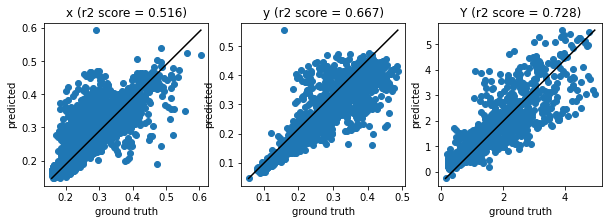

In [2]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model.pth',map_location=torch.device('cpu'))['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)
inverse_model.load_state_dict(torch.load('./models/inverse_model.pth',map_location=torch.device('cpu'))['model_state_dict'])
print(inverse_model)
x, y = test_loader.dataset.x.to(DEVICE), test_loader.dataset.y.to(DEVICE)
x_dim = x.size()[1]

        # get MSE for the design
y_pred = inverse_model(x, y)
x_pred = inverse_model(x, y)

print(y_pred)
cie_raw, param_raw, cie_pred, param_pred = evaluate_simple_inverse(forward_model, inverse_model, test_loader.dataset)

plot_cie_raw_pred(cie_raw, cie_pred)
plt.show()

### Tandem (fixed decoder)

Tandem net Design RMSE loss 3.488
Tandem Design RMSE loss 242.652
Reconstruct RMSE loss 0.264
Reconstruct RMSE loss raw 0.111


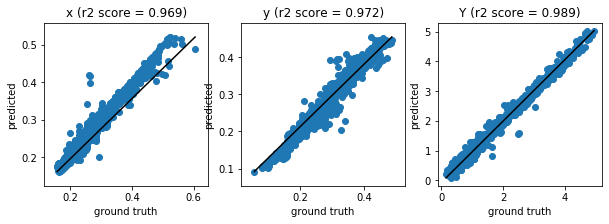

In [14]:
tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_accuracy(tandem_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

### VAE

Simple net Design RMSE loss 1.917
Simple net RMSE loss 138.044
Reconstruct RMSE loss 4.180
Reconstruct RMSE loss raw 1.203


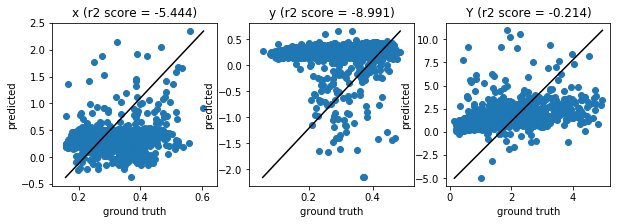

In [15]:
configs = get_configs('vae')
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

### GAN


Simple net Design RMSE loss 2.839
Simple net RMSE loss 182.818
Reconstruct RMSE loss 4.538
Reconstruct RMSE loss raw 2.339


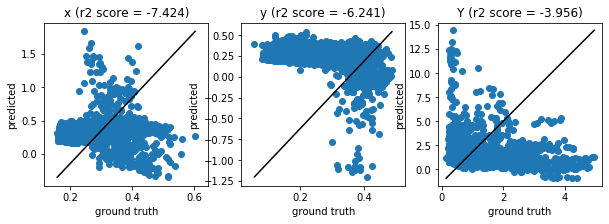

In [16]:
configs = get_configs('gan')
cgan = cGAN(3, 4, noise_dim = configs['noise_dim'], hidden_dim = 128).to(DEVICE)
cgan.load_state_dict(torch.load('./models/gan.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_gan_inverse(forward_model, cgan, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


### Inverse neural network

Simple net Design RMSE loss 2.078
Simple net RMSE loss 148.575
Reconstruct RMSE loss 5.553
Reconstruct RMSE loss raw 1.794


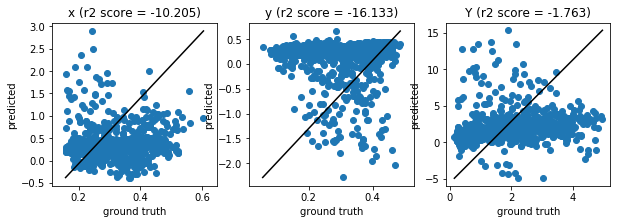

In [20]:
configs = get_configs('inn')
model = INN(configs['ndim_total'], configs['input_dim'], configs['output_dim'], dim_z = configs['latent_dim']).to(DEVICE)
model.load_state_dict(torch.load('./models/inn.pth')['model_state_dict'], strict=False)

train_loader, val_loader, test_loader = get_dataloaders('tandem_net')
cie_raw, param_raw, cie_pred, param_pred = evaluate_inn_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)
